## Using YOLOv5 for object detection using the Self Driving car Dataset

The following commands are executed to avoid errors in training 

In [1]:
%%capture
!apt-get install libstdc++6 -y
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt-get update -y
!apt-get upgrade -y
!apt-get dist-upgrade -y

In [2]:
%%capture
!pip install torch==1.7
!pip install numpy==1.17
!pip install PyYAML==5.3.1
!pip install torchvision==0.7.0
!pip install split-folders

from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

We install yolov5 package from from the repo

In [3]:
!git clone https://github.com/ultralytics/yolov5
%cd ./yolov5
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

Cloning into 'yolov5'...
remote: Enumerating objects: 10086, done.
remote: Total 10086 (delta 0), reused 0 (delta 0), pack-reused 10086
Receiving objects: 100% (10086/10086), 10.41 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (6989/6989), done.
/kaggle/working/yolov5
Note: checking out 'ec72eea62bf5bb86b0272f2e65e413957533507f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ec72eea Merge remote-tracking branch 'origin/master'


In [4]:
!ls ./

Dockerfile  data	inference	  test.py	  utils
LICENSE     detect.py	models		  train.py	  weights
README.md   hubconf.py	requirements.txt  tutorial.ipynb


We download the data from Roboflow 

https://public.roboflow.com/object-detection/self-driving-car/

In [6]:
!ls ./export

images	labels


In [7]:
!cat ./README.dataset.txt

# Udacity Self Driving Car > fixed-small
https://public.roboflow.ai/object-detection/self-driving-car

Provided by [Roboflow](https://roboflow.ai)
License: MIT

# Overview

The [original Udacity Self Driving Car Dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) is missing labels for thousands of pedestrians, bikers, cars, and traffic lights. This will result in poor model performance. When used in the context of self driving cars, this could even lead to human fatalities.

We re-labeled the dataset to correct errors and omissions. We have provided convenient downloads in many formats including VOC XML, COCO JSON, Tensorflow Object Detection TFRecords, and more.

Some examples of labels missing from the original dataset:
![Examples of Missing Labels](https://i.imgur.com/A5J3qSt.jpg)

# Stats

The dataset contains 97,942 labels across 11 classes and 15,000 images. There are 1,720 null examples (images with no labels).

All images are 1920x1200 (download size ~

We train val test split the data into folders using the ratio 8:1:1

In [8]:
import splitfolders

input_folder = "./export/"
output_folder = "./export/output/"
splitfolders.ratio(input_folder, output=output_folder, 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None)

Copying files: 59600 files [00:34, 1721.26 files/s]


In [9]:
!ls ./export/output/

test  train  val


The configuration file of the dataset is as follows

In [10]:
!cat ./data.yaml

train: ../train/images
val: ../valid/images

nc: 11
names: ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']

We correct the directory of the train and val data in the configuration file

In [11]:
%%writefile ./data_new.yaml
train: ./data/train/images
val: ./data/val/images

nc: 11
names: ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']

Writing ./data_new.yaml


In [12]:
!mkdir ./data/train/
!cp -rf ./export/output/train/* ./data/train/
!mkdir ./data/test/
!cp -rf ./export/output/test/* ./data/test/
!mkdir ./data/val/
!cp -rf ./export/output/val/* ./data/val/

One sample annotation bbox is as follows

In [13]:
!cat ./export/output/train/labels/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.txt

10 0.43359375 0.48828125 0.0166015625 0.0283203125
1 0.458984375 0.494140625 0.0244140625 0.0263671875
1 0.5087890625 0.4970703125 0.0283203125 0.0380859375
2 0.9287109375 0.5107421875 0.0361328125 0.21875

The configuration file of the YOLOv5s is as follows, several other models can be used here like YOLOv5m, YOLOv5l and YOLOv5x

In [14]:
!cat ./models/yolov5x.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [116,90, 156,198, 373,326]  # P5/32
  - [30,61, 62,45, 59,119]  # P4/16
  - [10,13, 16,30, 33,23]  # P3/8

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
  ]

# YOLOv5 head
head:
  [[-1, 3, BottleneckCSP, [1024, False]],  # 9

   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

We edit the model configuration file by changing the number of classes to 11

In [15]:
%%writefile ./models/yolov5x_new.yaml
# parameters
nc: 11  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [116,90, 156,198, 373,326]  # P5/32
  - [30,61, 62,45, 59,119]  # P4/16
  - [10,13, 16,30, 33,23]  # P3/8

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
  ]

# YOLOv5 head
head:
  [[-1, 3, BottleneckCSP, [1024, False]],  # 9

   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 18 (P3/8-small)

   [-2, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 22 (P4/16-medium)

   [-2, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 26 (P5/32-large)

   [[], 1, Detect, [nc, anchors]],  # Detect(P5, P4, P3)
  ]

Writing ./models/yolov5x_new.yaml


In [16]:
!rm ./data/coco.yaml
!rm ./data/coco128.yaml
!rm ./data/get_coco2017.sh

To download the models weights, we need to run the following bash

In [17]:
!cat ./weights/download_weights.sh
#!sh ./weights/download_weights.sh

#!/bin/bash
# Download common models

python3 -c "from utils.google_utils import *;
attempt_download('weights/yolov5s.pt');
attempt_download('weights/yolov5m.pt');
attempt_download('weights/yolov5l.pt');
attempt_download('weights/yolov5x.pt')"


Or download the model weights directly

In [18]:
%%capture
!wget https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5x.pt
!cp ./yolov5x.pt ./weights/yolov5x.pt
!rm ./yolov5x.pt

Now We train the model 

- img size 256

- batch 4 - 4 images per batch
    
- epochs 30 - train for 30 epochs
    
- data ./data.yaml - path to dataset config
    
- cfg ./models/yolov5x.yaml - model config
    
- weights yolov5x.pt - use pre-trained weights from the YOLOv5x model
    
- name yolov5x_cars - name of our model
    
- cache - cache dataset images for faster training


Other parameters like learning rate momentum can be changed in the train.py file

In [19]:
!python ./train.py --img 256 --batch 4 --epochs 30 \
  --data ./data_new.yaml --adam --cfg  ./models/yolov5x_new.yaml --weights '' \
  --name yolov5x_cars --cache

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=True, batch_size=4, bucket='', cache_images=True, cfg='./models/yolov5x_new.yaml', data='./data_new.yaml', device='', epochs=30, evolve=False, img_size=[256], multi_scale=False, name='yolov5x_cars', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/

              from  n    params  module                                  arguments                     
  0             -1  1      8800  m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      7/29     9.01G   0.05558   0.07014   0.01217    0.1379        25       256
               Class      Images     Targets           P           R      mAP@.5
                 all    2.98e+03    1.95e+04       0.217       0.265       0.193      0.0836

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size
      8/29     9.01G   0.05461   0.06891   0.01171    0.1352        40       256
               Class      Images     Targets           P           R      mAP@.5
                 all    2.98e+03    1.95e+04       0.223       0.259         0.2      0.0886

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size
      9/29     9.01G   0.05398   0.06824   0.01158    0.1338        13       256
               Class      Images     Targets           P           R      mAP@.5
                 all    2.98e+03    1.95e+04       0.234       0.252       0.204      0.0932

     Epoch   gpu_mem      GIoU       obj       cls     total   targets

In [20]:
!ls ./

Dockerfile	     export		       test_batch0_gt.jpg
LICENSE		     hubconf.py		       test_batch0_pred.jpg
README.dataset.txt   inference		       train.py
README.md	     labels.png		       train_batch0.jpg
README.roboflow.txt  models		       train_batch1.jpg
__pycache__	     requirements.txt	       train_batch2.jpg
data		     results.png	       tutorial.ipynb
data.yaml	     results_yolov5x_cars.txt  utils
data_new.yaml	     runs		       weights
detect.py	     test.py


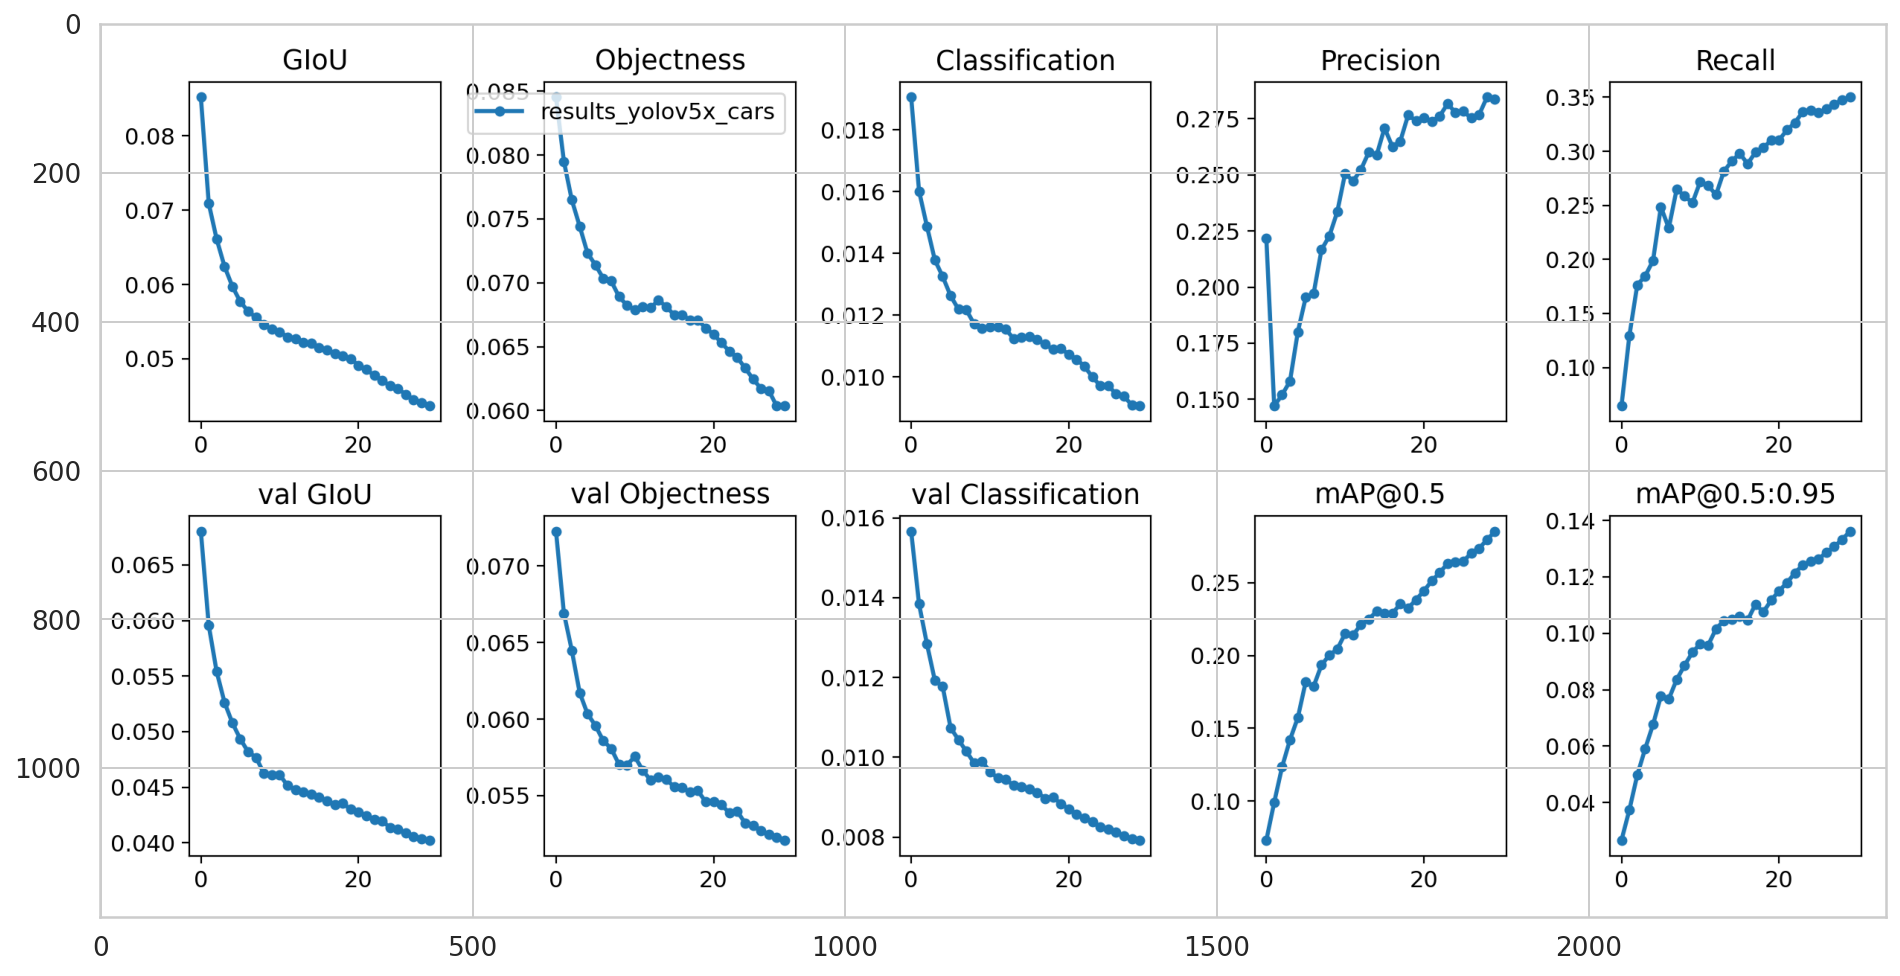

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('./results.png')
plt.imshow(img)
plt.show()

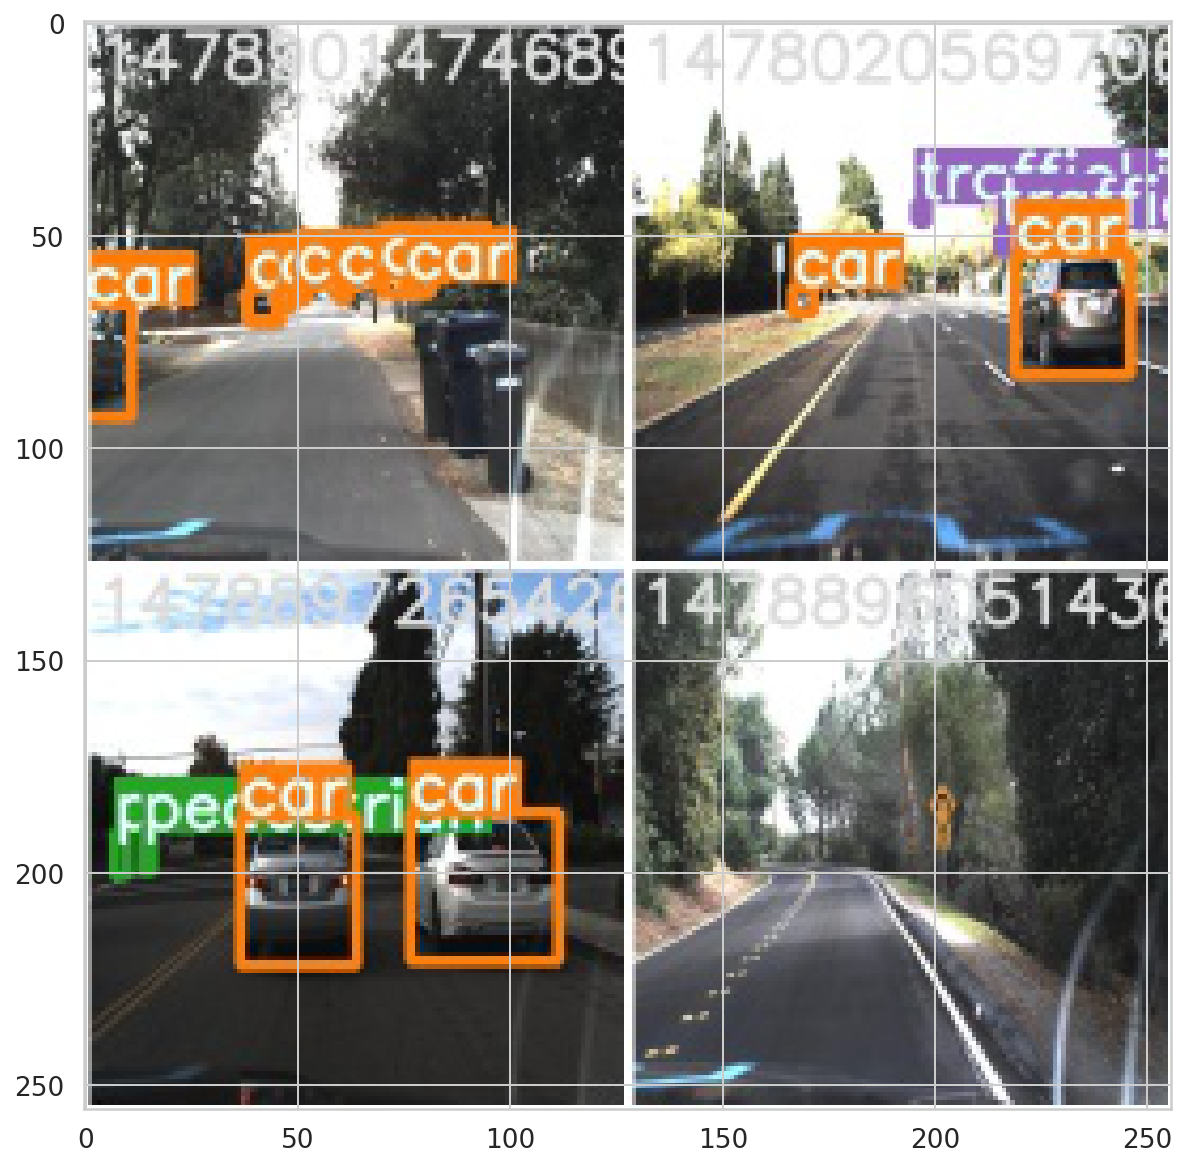

In [26]:
img = mpimg.imread('./test_batch0_gt.jpg')
plt.imshow(img)
plt.show()